In [ ]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install pyttsx3
!pip install gTTS
!pip install pydub
!pip install playsound

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-b8riykwf
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-b8riykwf
  Resolved https://github.com/huggingface/transformers.git to commit 8c12690cecbb97e187861e386f7a0ac790e4236c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
import requests
import pyttsx3
from gtts import gTTS
from IPython.display import Audio
from pydub import AudioSegment
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)

  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


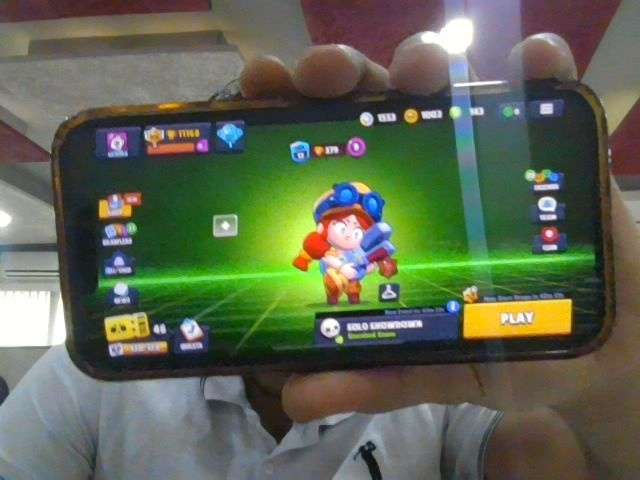

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

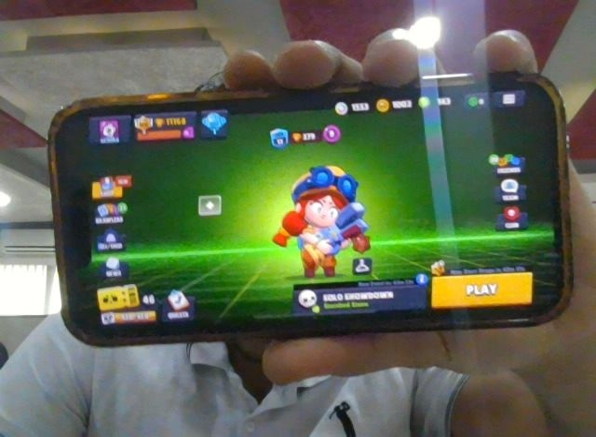

In [ ]:
from PIL import Image

# Open the image from the specified path
image = Image.open("/content/photo.jpg").convert('RGB')

# Resize the image
image = image.resize((596, 437))

# Display the image (assuming you have a display function like `display`)
display(image)


In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch


processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [ ]:
inputs = processor(image, return_tensors="pt").to(device, torch.float32)  # Specify float32 explicitly

generated_ids = model.generate(**inputs, max_length=50, min_length=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline = generated_text + "\n"

    output_file.write(text_with_newline)

    speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


a person holding up a cell phone with a game on it in front of them in a room


In [ ]:
prompt = "this is an image of"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=60, min_length=30)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline=generated_text + "\n"
    output_file.write(text_with_newline)
speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


Both `max_new_tokens` (=60) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


a person holding up a cell phone with a game on it in front of them. it is showing a game on it


In [ ]:
prompt = "Question: What kind of image is the person trying to display? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=60, min_length=30)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

print(generated_text)
with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline=generated_text + "\n"
    output_file.write(text_with_newline)
speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


Both `max_new_tokens` (=60) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


A clown!I'm not sure if this is a good thing or a bad thing.


In [ ]:
context = [
   ("What kind of image is the person playing ?", "He is showing the image of a something on this phone"),
   ("Where is he showing it?", "In his phone")
]
question = "What for?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: What kind of image is the person playing ? Answer: He is showing the image of a something on this phone. Question: Where is he showing it? Answer: In his phone. Question: What for? Answer:


In [ ]:
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=52, min_length=30)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)
with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline=generated_text + "\n"
    output_file.write(text_with_newline)
speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


Both `max_new_tokens` (=52) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


To show it to his friends.
